# Daily coffee price

Precio diario del Café (creo que en EEUU) desde el 03-01-2000 hasta el 02-09-2020. Los valores están dados en USD.

In [312]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

## 1. Carga de Datos y análisis de la serie temporal

In [289]:
df = pd.read_csv('./data/coffee.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


In [284]:
df.tail()

,Date,Open,High,Low,Close,Volume,Currency
5741,2022-08-29,240.55,240.55,240.55,240.50,1,USD
5742,2022-08-30,238.75,241.75,238.75,239.15,14,USD
5743,2022-08-31,240.75,240.75,239.65,239.10,12,USD
5744,2022-09-01,238.55,238.55,236.60,236.35,6,USD
5745,2022-09-02,232.50,234.05,228.28,228.42,0,USD


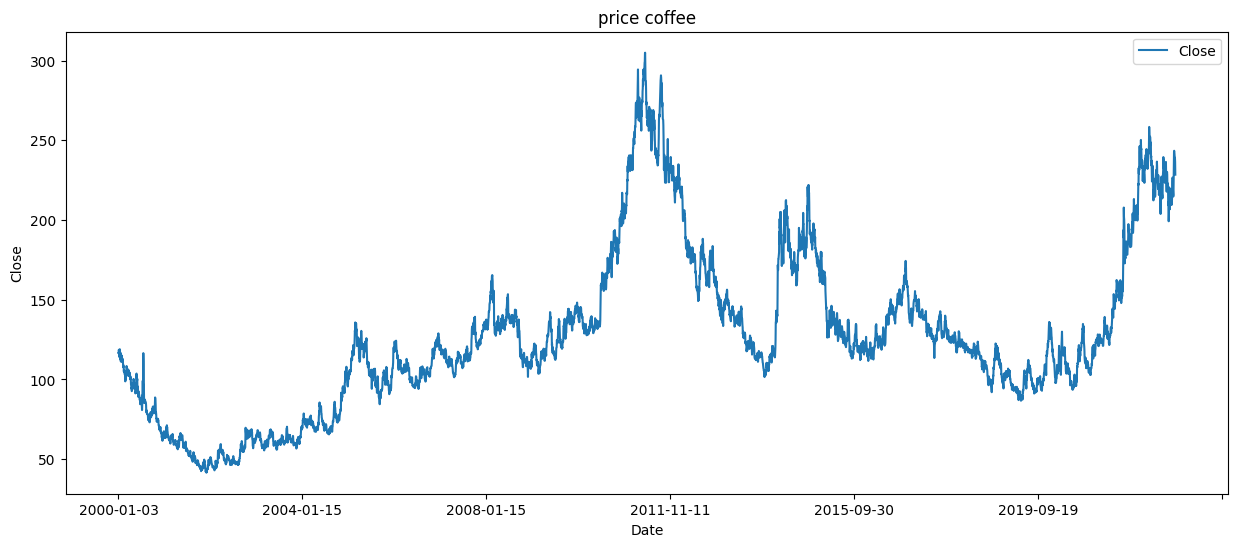

In [228]:
df.plot(x = "Date", y= "Close", figsize=(15, 6))
plt.title(f'price coffee')
plt.xlabel('Date')
plt.ylabel("Close")
plt.show()

### Descripción de las observaciones 

La serie parece no presentar ciclos ni estaciones marcadas. Es no acotada, tiene su punto máximo de aproximandamente 300 USD al rededor del año 2011 y un punto mínimo por debajo de los 50 USD en el año 2002 o 2003 aproximadamente. En principio pareciera no estacionaria porque la varianza bastante variable. Pareciera tener una tendencia a crecer muy sutil.

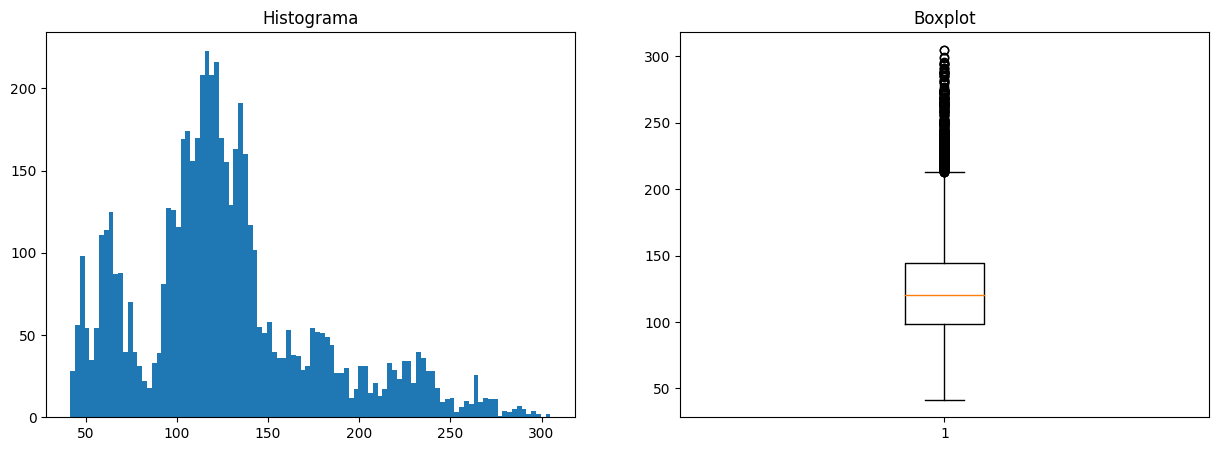

In [229]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
ax1.set_title('Histograma')
ax1.hist(df["Close"], bins = 100)
ax2.set_title("Boxplot")
ax2.boxplot(df["Close"])

plt.show()

si observamos la distribución tiene una especie de asímetria positiva, sin embargo no parece tener una distribución reconocible.

## 2. Descomposición con el modelo aditivo

In [242]:
period = 300
df_1 = df.set_index(pd.DatetimeIndex(df['Date']))
df_1.sort_index(ascending=True, inplace=True)
df_1=df_1['Close']

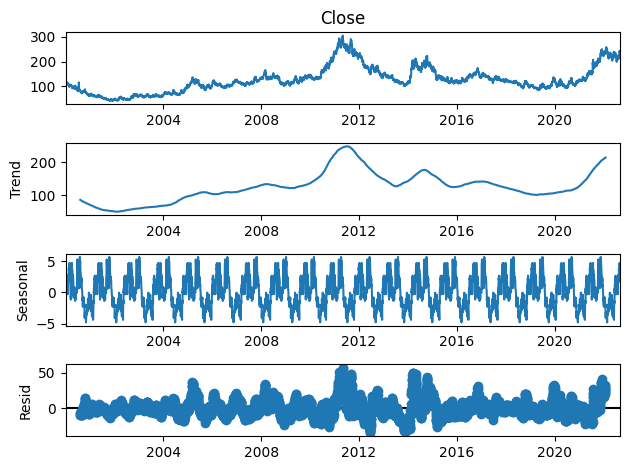

In [243]:
decompose = seasonal_decompose(df_1, model='additive', period=period)
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
decompose.plot();

## 3. Ajuste de modelo determinístico a la tendencia

Se ajusta un modelo lineal a la tendencia dado que no se observa que la tendencia sea cíclica o que siga una forma polinómica.

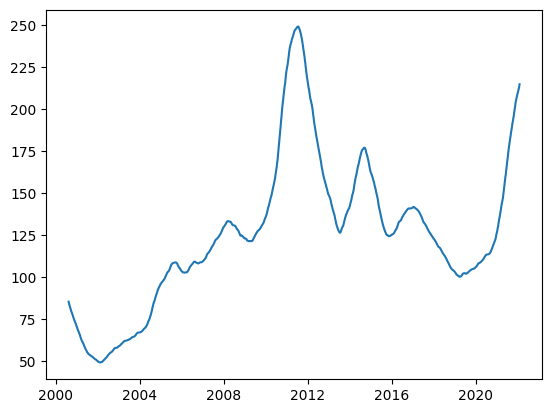

In [274]:
#graficamos la tendencia obtenida de la descomposición
plt.plot(trend)

In [185]:
def objective(x,a,b):
    return a * x + b 

In [265]:
x = np.linspace(0, 5445, 5446)
y = trend.dropna(axis=0)

popt, _ = curve_fit(objective, x, y)
a, b = popt
y_line = objective(x,a,b)

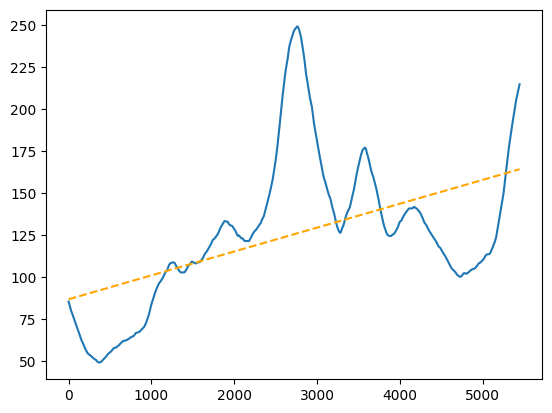

In [277]:
plt.plot(x,y)
plt.plot(x, y_line, '--', color = 'orange')

Podemos ver que lo que se había observado en la primera descripción sobre la tendencia a crecer sutilmente se corroborar con el ajuste de un modelo lineal. 

## 4. Estacionariedad

### 4.1 Verificación de estacionariedad

#### 4.1.1 Gráficas de autocorrealción y autocorrelación parcial

In [290]:
df.Date = pd.to_datetime(df.Date,yearfirst=True)
df.set_index('Date',inplace=True)
df = df.asfreq('b','ffill')

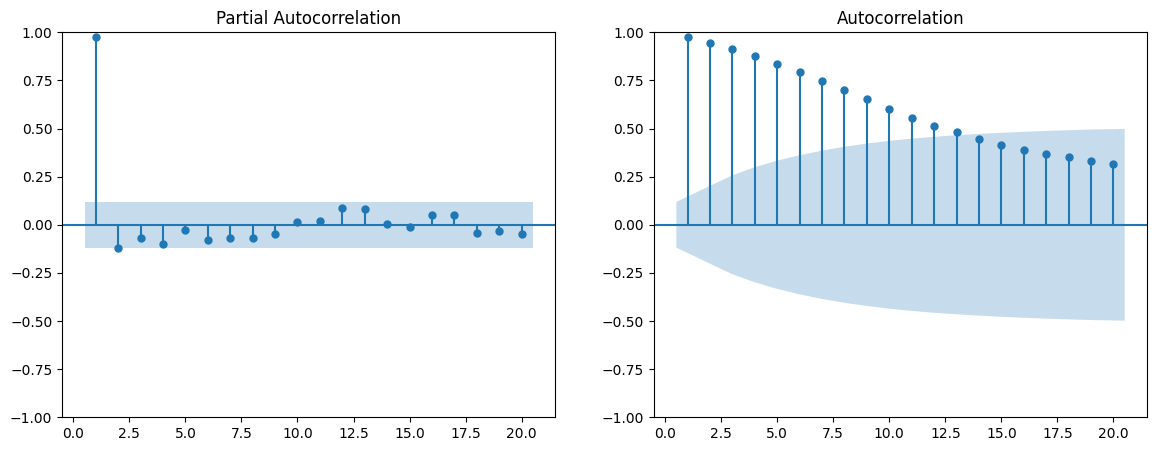

In [328]:
data = df.Close.resample('M').mean()

fig = plt.figure(figsize=(14,5))
ax_1 = fig.add_subplot(121)
plot_pacf(data ,lags=20, zero=False, method ="ywm", ax=ax_1)

ax_2 = fig.add_subplot(122)
plot_acf(data, lags=20, zero=False, ax=ax_2);

Vemos que la función de correlación tarda bastante en caer, es un primer indicio que la serie no es estacionaria.

#### 4.1.2 Test de Dickey-Fuller

In [310]:
test = adfuller(data)
test

(-1.4712344560827693,
 0.5476902360797826,
 2,
 270,
 {'1%': -3.4548039258751206,
  '5%': -2.872304928618605,
  '10%': -2.5725063100137175},
 1861.340990777597)

Observando el test tenemos:

p-valor de 0.5 bastante grande que de entrada nos dice que no es estacionaria.

Si comparamos el estadístico con el umbral 0.05 tenemos que igual es más grande por lo tanto es no estacionaria. 

#### 4.1.3 Test KPSS

In [317]:
kpsstest = kpss(data)
kpsstest

D:\FACULTAD\ESPECIALIZACIÓN\4. CUARTO BIMESTRE\Series_temporales\env\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.9257997214985456,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Podemos ver que el p-valor para este test es menor que el umbral 0.05. Por lo tanto rechazamos la hipótesis nula lo que nos arroja que para este test la serie si es estacionaria al rededor de una tendencia determinística. 

Los resultados que obtenemos de los test es que para Dickey-Fuller no es estacionaria pero para KPSS si. Entonces se podría concluir que hay una componente de tendencia. Lo que podría hacerse para llegar a una serie estacionaria es corregir la tendencia.


### 4.2 Transformación

Como queremos remover la tendencia podemos usar el método de diferenciación y volver a probar los test sobre la serie trnasformada. 

<AxesSubplot:xlabel='Date'>

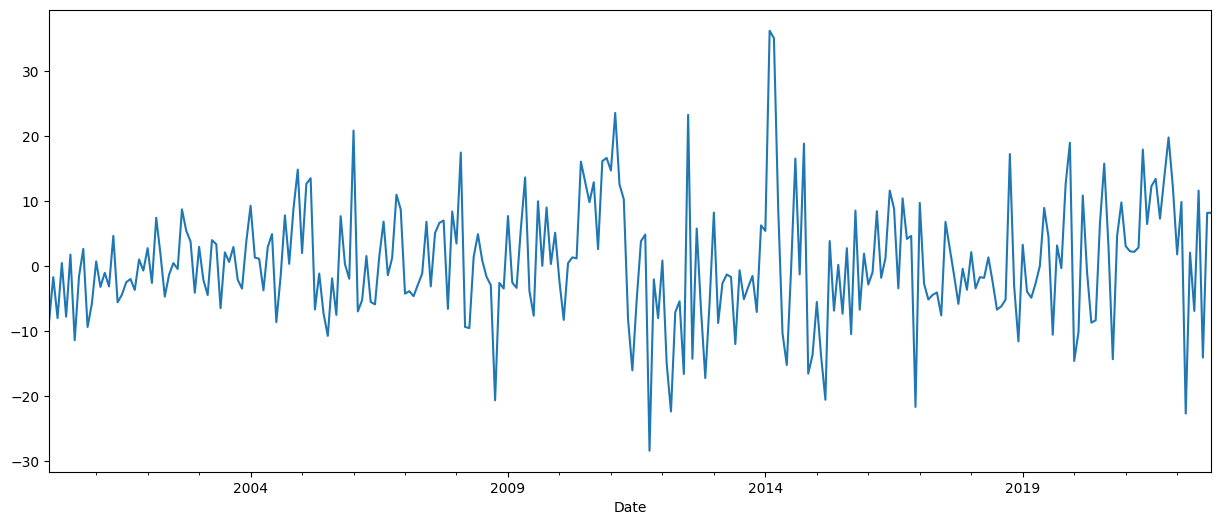

In [338]:
data_diff = data.diff(1)
data_diff.dropna().plot(figsize=(15, 6))

Probamos los test sobre la serie transformada.

In [339]:
test_diff = adfuller(data_diff.dropna())
test_diff

(-13.472400425062371,
 3.362485782354874e-25,
 0,
 271,
 {'1%': -3.4547128138328875,
  '5%': -2.8722649771800155,
  '10%': -2.5724850011573914},
 1855.2452896538448)

Verificamos que el p-valor es bastante más pequeño que 0.05. Por lo tanto esta serie transformada es estacionaria.

In [340]:
kpss_diff = kpss(data_diff.dropna())
kpss_diff

D:\FACULTAD\ESPECIALIZACIÓN\4. CUARTO BIMESTRE\Series_temporales\env\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.10385434373502718,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Verificamos que el p-valor es mayor a 0.05 por lo tanto para este test la serie también es estacionaria. 

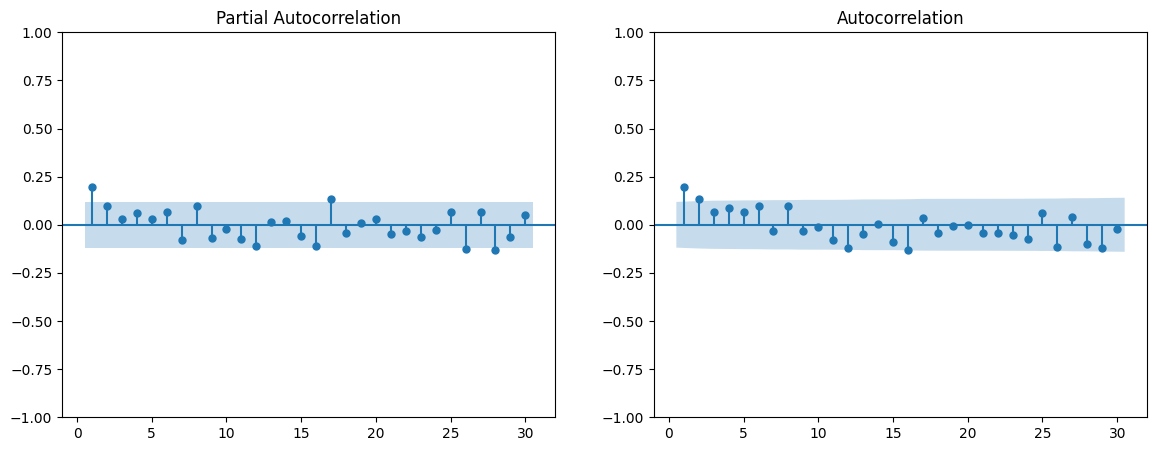

In [341]:
fig = plt.figure(figsize=(14,5))
ax_1 = fig.add_subplot(121)
plot_pacf(data_diff.dropna() ,lags=30, zero=False, method ="ywm", ax=ax_1)

ax_2 = fig.add_subplot(122)
plot_acf(data_diff.dropna(), lags=30, zero=False, ax=ax_2);